# Spatial derivatives using FFT

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

As an example for the rest of this tutorial, we use a surface velocity field from an oceanic simulation made with the NEMO model using a gridsize of 1/60°.

In [2]:
filename = "/data/NATL60/SampleData/NATL60_BigBox_Surf_SSH_UV_2013_03.nc"
ds = xr.open_dataset(filename, chunks={'time_counter': 10, 'x':200, 'y':200})
ds_sub = ds.isel(x=slice(None, 1001), y=slice(None, 1001))

In [3]:
u = ds_sub['vozocrtx']
v = ds_sub['vomecrty']
uc = u + 1j * v

## Checking the direct and inverse Fourier transforms
The computation of the Fourier transform on DataArray objects is achieved using `xr.spectral.fft.fft`. Here we compute the Fourier transform of the two velocity components $(u, v)$ along the two spatial dimensions $(x, y)$. In order to properly scale the wavenumbers, we set the spatial sampling to 1600 m, corresponding to the approximate gridsize of the model.

In [4]:
import xscale.spectral.fft as xfft
uhat = xfft.fft(u, dim=('x', 'y'), dx={'x': 1600, 'y': 1600}, sym=True)
vhat = xfft.fft(v, dim=('x', 'y'), dx={'x': 1600, 'y': 1600}, sym=True)

Once the Fourier transform has been applied, we apply the inverse Fourier tranfsorm 

In [5]:
uback = xfft.ifft(uhat, real=True)
vback = xfft.ifft(vhat, real=True)

In [36]:
u_test = u.isel(time_counter=0).compute()
uback_test = uback.isel(time_counter=0).compute()
v_test = v.isel(time_counter=0).compute()
vback_test = vback.isel(time_counter=0).compute()

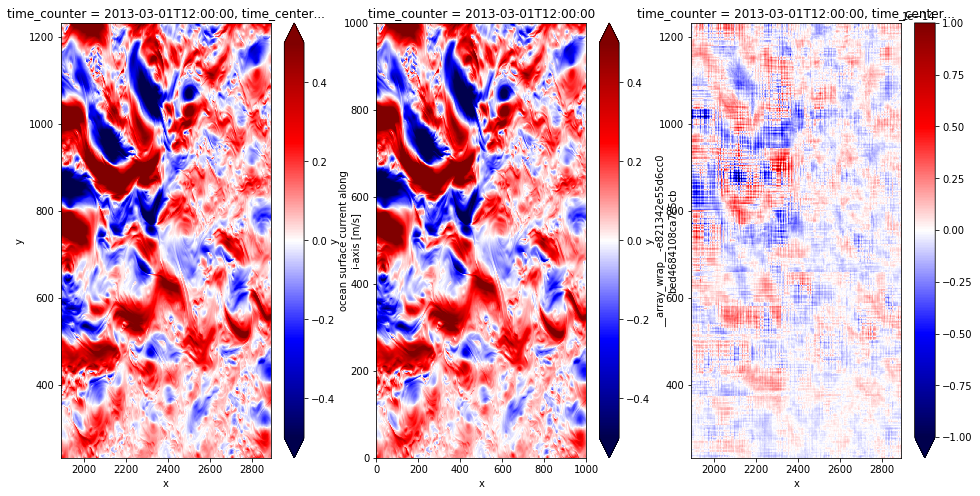

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
u_test.plot(vmin=-0.5, vmax=0.5, cmap='seismic')
plt.subplot(132)
uback_test.plot(vmin=-0.5, vmax=0.5, cmap='seismic')
plt.subplot(133)
(u_test - uback_test).plot(cmap='seismic', vmin=-1e-14, vmax=1e-14)

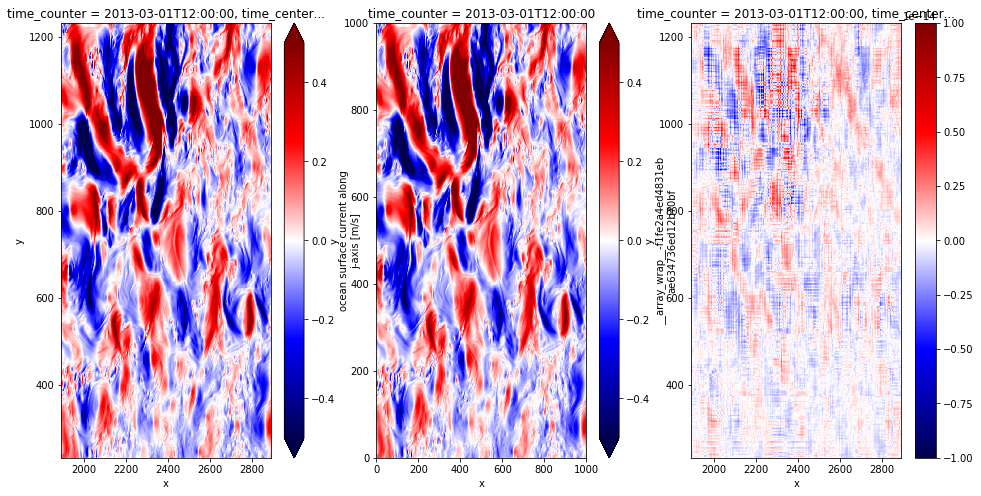

In [35]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
v_test.plot(vmin=-0.5, vmax=0.5, cmap='seismic')
plt.subplot(132)
vback_test.plot(vmin=-0.5, vmax=0.5, cmap='seismic')
plt.subplot(133)
(v_test - vback_test).plot(cmap='seismic', vmin=-1e-14, vmax=1e-14)

## Compute velocity derivatives in the Fourier space
The spatial derivatives can be computed in the Fourier space in a straighforward way and with accuracy. 

\begin{equation}
\frac{\partial u}{\partial x} = 2 \pi
\end{equation}

Based on xarray, dask and xscale, we thus define the function `velocity_derivatives` to compute those velocity derivatives in the Fourier space and store them into a Dataset.

In [9]:
def velocity_derivatives(u, v, xdim='x', ydim='y', dx={'x': 1600, 'y': 1600}):
    uhat = xfft.fft(u, dim=(xdim, ydim), dx=dx, sym=True)
    vhat = xfft.fft(v, dim=(xdim, ydim), dx=dx, sym=True)
    k = uhat['f_%s' % xdim]
    l = vhat['f_%s' % ydim]
    u_x_hat = uhat * 2 * np.pi * 1j * k 
    u_y_hat = uhat * 2 * np.pi * 1j * l 
    v_x_hat = vhat * 2 * np.pi * 1j * k
    v_y_hat = vhat * 2 * np.pi * 1j * l
    ds_derivatives = xr.Dataset({'u_x': xfft.ifft(u_x_hat),
                                 'u_y': xfft.ifft(u_y_hat),
                                 'v_x': xfft.ifft(v_x_hat),
                                 'v_y': xfft.ifft(v_y_hat)
                                })
    return ds_derivatives

The later function is simplu

In [10]:
derivatives = velocity_derivatives(u, v)
print(derivatives)

<xarray.Dataset>
Dimensions:       (time_counter: 31, x: 1001, y: 1001)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2013-03-01T12:00:00 ...
Dimensions without coordinates: x, y
Data variables:
    v_y           (time_counter, y, x) float64 dask.array<shape=(31, 1001, 1001), chunksize=(10, 1001, 1001)>
    u_y           (time_counter, y, x) float64 dask.array<shape=(31, 1001, 1001), chunksize=(10, 1001, 1001)>
    v_x           (time_counter, y, x) float64 dask.array<shape=(31, 1001, 1001), chunksize=(10, 1001, 1001)>
    u_x           (time_counter, y, x) float64 dask.array<shape=(31, 1001, 1001), chunksize=(10, 1001, 1001)>


From the later derivatives, several interesting quantity to better describe the flow can be computed:
* The vorticity $\zeta = v_y - u_x$, which characterizes the capacity of the fluid to rotate
* The divergence $ \delta = u_x + v_y$
* The strain

In [11]:
vorticity = derivatives['v_y'] - derivatives['u_x']
divergence = derivatives['u_x'] + derivatives['v_y']
strain = ((derivatives['u_x'] - derivatives['v_y']) ** 2 + (derivatives['u_y'] - derivatives['v_x']) ** 2) ** 0.5

At this point, no computation was performed and only the dask graph was build. The computation will be launched once the user ask for a plot or force the computation using `.compute()`. 

In [12]:
%timeit vorticity.isel(time_counter=0).compute()

4.53 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here, we will load only the first timestep of each variables.

In [13]:
vorticity_t0 = vorticity.isel(time_counter=0).compute()
divergence_t0 = divergence.isel(time_counter=0).compute()
strain_t0 = strain.isel(time_counter=0).compute()

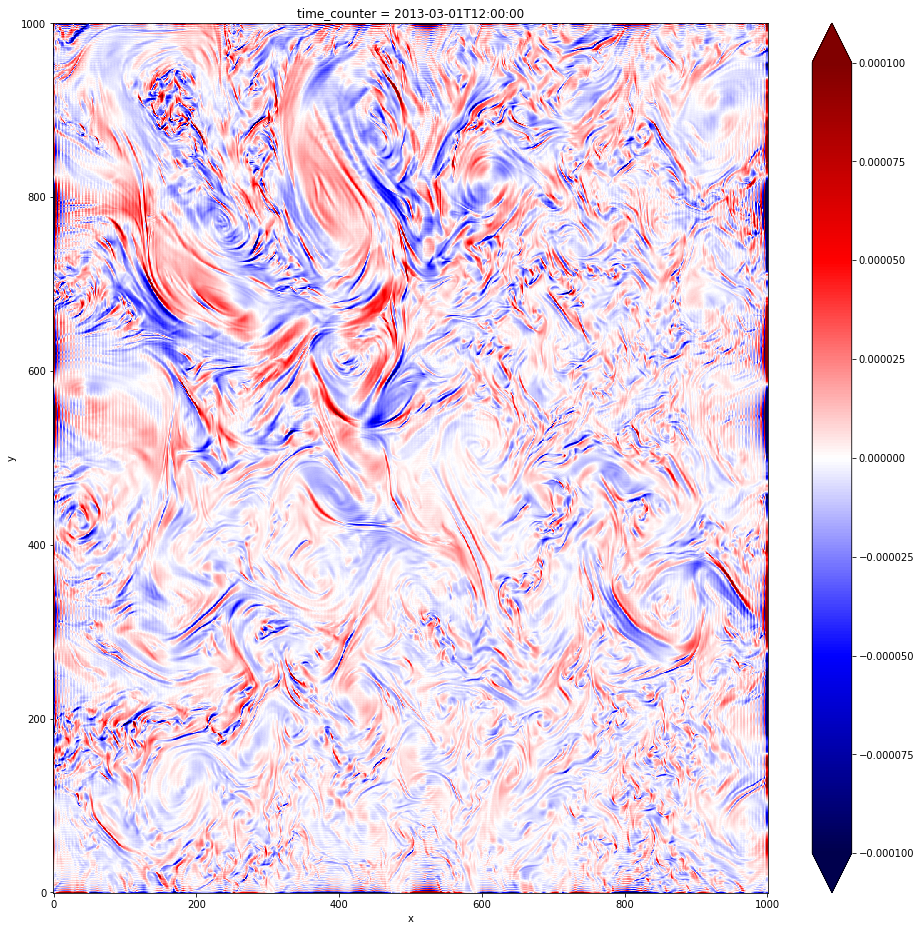

In [14]:
plt.figure(figsize=(16, 16))
vorticity_t0.plot(cmap='seismic', vmin=-1e-4, vmax=1e-4)

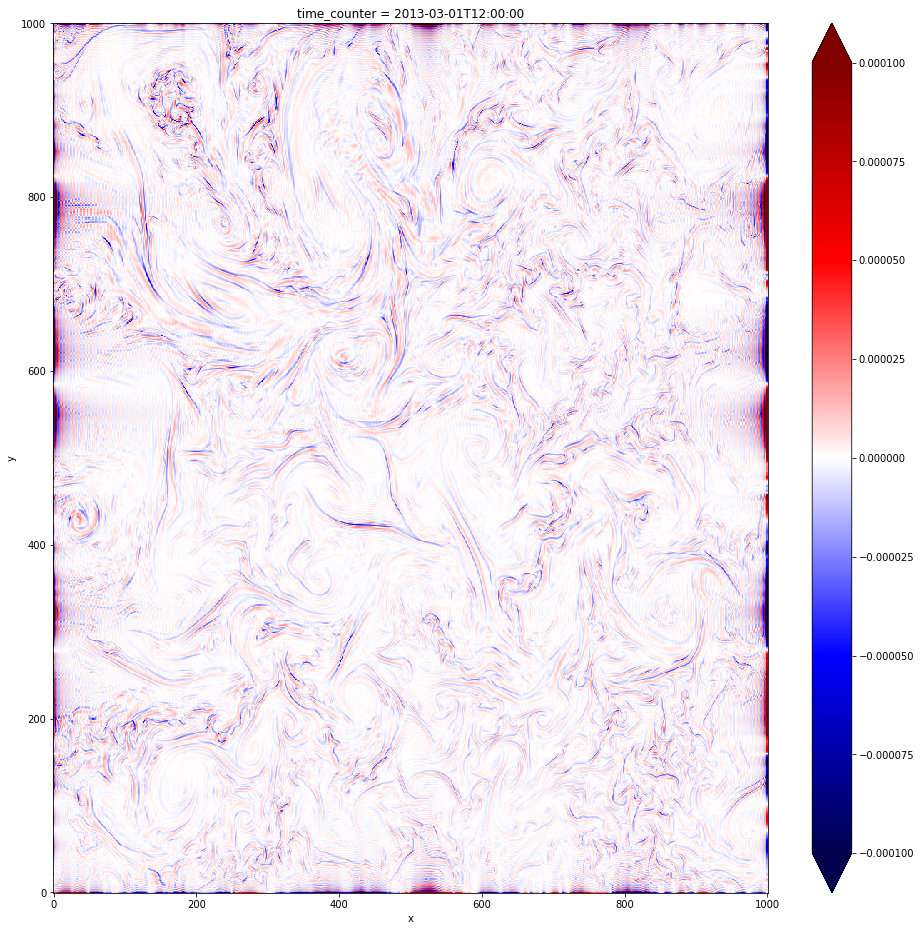

In [15]:
plt.figure(figsize=(16, 16))
divergence_t0.plot(cmap='seismic', vmax=1e-4, vmin=-1e-4)

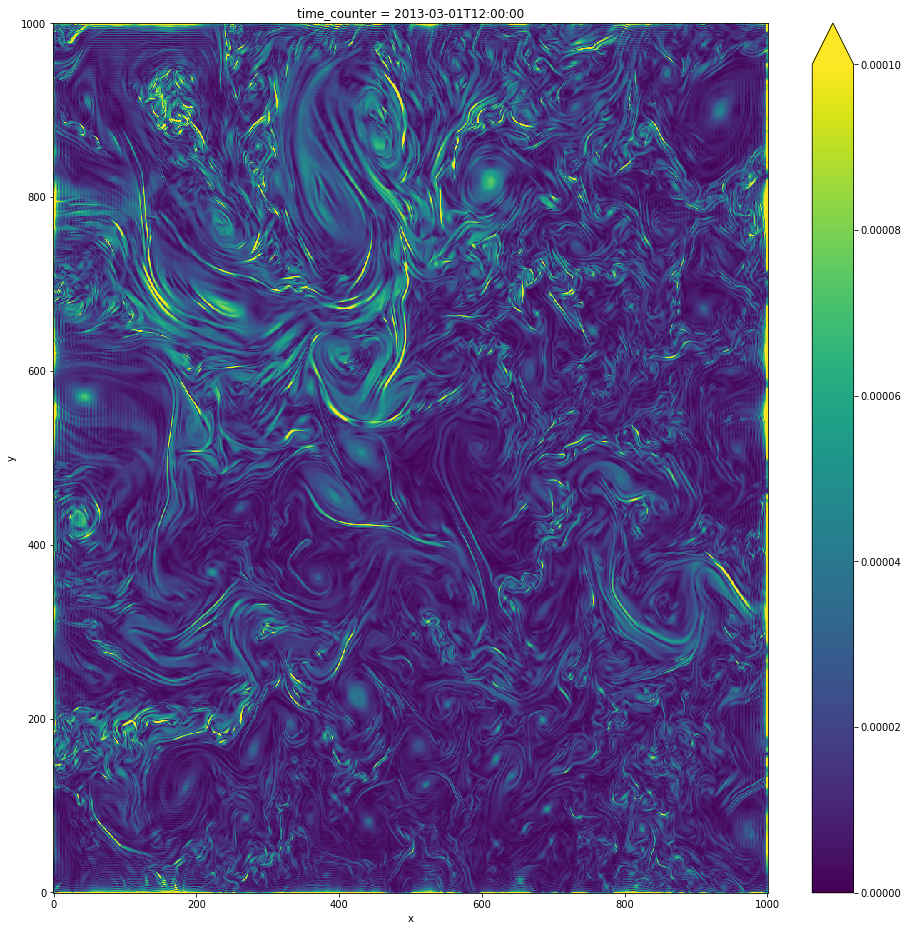

In [16]:
plt.figure(figsize=(16, 16))
strain_t0.plot(cmap='viridis', vmin=0, vmax=1e-4)